In [2]:
import warnings
import os
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# text processing
from wordcloud import WordCloud
import nltk
import contractions
import pyLDAvis
import pyLDAvis.gensim_models
import gensim

c:\Users\Vincent\Anaconda3\envs\oc_projet_6\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Users\Vincent\Anaconda3\envs\oc_projet_6\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
root_dir = 'D:/OpenClassrooms/projet_6' 


warnings.filterwarnings('ignore')


# for bigger plots
plt.rcParams['figure.figsize'] = 12, 8


# initialize nltk
download_nltk = False
download_dir_nltk = 'D:/nltk_data'

download_list = ['punkt', 
                 'stopwords', 
                 'wordnet', 
                 'omw-1.4', 
                 'averaged_perceptron_tagger', 
                 'tagsets', 
                ]

if download_nltk:
    for asset in download_list:
        nltk.download(asset, download_dir=download_dir_nltk)

# First look

In [4]:
chunk_size = 100000
df_name = 'yelp_academic_dataset_review'


df_path = root_dir + '/data/' + df_name + '.json'
iterable_df = pd.read_json(df_path, lines=True, chunksize=chunk_size)
print('iterable_df:', type(iterable_df), '\n')

# "iterable_df" is not a dataframes.
# It needs to be iterated over to unroll the dataset in successive dataframes

# to get a view of the df
for df_chunk in iterable_df:
    break
print(df_chunk.shape)
df_chunk.head()

iterable_df: <class 'pandas.io.json._json.JsonReader'> 

(100000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [5]:
# create one-star-reviews df and save it
one_star_save_name = 'one_star_texts'
create_dataset = False


if create_dataset:
    # initialize one_star df
    to_keep = ['text']
    one_star = pd.DataFrame(columns=to_keep)

    # populate it
    iterable_df = pd.read_json(df_path, lines=True, chunksize=chunk_size)
    for i, df_chunk in enumerate(iterable_df):
        df_filter = df_chunk[to_keep][df_chunk['stars'] == 1]
        one_star = pd.concat([one_star, df_filter], axis=0)
    
    # save it
    one_star_save_path = root_dir + '/data/' + one_star_save_name + '.csv'
    one_star.to_csv(one_star_save_path, index=False)

# load one_star back
one_star_path = root_dir + '/data/' + one_star_save_name + '.csv'
one_star = pd.read_csv(one_star_path)
one_star

,text
0,I am a long term frequent customer of this est...
1,If you want to pay for everything a la carte t...
2,The TV shows are $4.99 and they have commercia...
3,"If I could give it a zero, I would. I order a ..."
4,We visited once and were very disappointed in ...
...,...
1069556,Sat at the bar for 10 minutes and didn't get s...
1069557,"The supper club is ridiculously expensive. So,..."
1069558,The worst. Wish I had read all the other revie...
1069559,Temple University blatantly disregards freedom...


# Preprocessing

In [6]:
# select sample data
nb_samples = 50000

data_sample = one_star.sample(random_state=0, n=nb_samples)
data_sample

,text
340462,"Bad food, lousy menu, poor service, dirty plac..."
559902,"I don't know what it is about this store, the ..."
978596,We got the drinks quickly but waited 50 minute...
76987,I needed a drug test for my future employer. I...
797931,"Needed a tow, called at 11:56a and the eta was..."
...,...
788303,"DO NOT, I REPEAT, DO NOT WASTE YOUR MONEY GOIN..."
449622,It's hard to say what I really want to say abo...
96168,Disappointed that they excessively charged for...
873963,The worst. Period.\n\nStarted with the Cokes ...


In [7]:
def lower_case(text):
    return text.lower()


def remove_contractions(text):
    new_text = contractions.fix(text, slang=True)
    return new_text


def tokenize(text):
    tokens = nltk.tokenize.WordPunctTokenizer().tokenize(text)
    return tokens


def delete_groups(tokens):
    adjectives = ['JJ', 'JJR', 'JJS']
    adverbs = ['RB', 'RBR', 'RBS', 'WRB']
    modal_auxiliary = ['MD']
    to_del = adjectives + adverbs + modal_auxiliary
    
    tokens_tagged = nltk.pos_tag(tokens)
    new_tokens = []
    for token in tokens_tagged:
        if token[1] not in to_del:
            new_tokens.append(token[0])
    return new_tokens


def delete_numbers(tokens):
    new_tokens = []
    for token in tokens:
        try:
            float(token)
        except ValueError:
            new_tokens.append(token)
            
    return new_tokens
      

def delete_stop_words(tokens):
    excluded_words = []
    language = 'english'
    
    stop_words = nltk.corpus.stopwords.words(language)
    punct = list(string.punctuation)
    new_stop_words = list(set(stop_words + excluded_words + punct))
    new_tokens = [token for token in tokens if token not in new_stop_words]
    return new_tokens


def lemmatize(tokens):
    lemma = nltk.stem.WordNetLemmatizer()
    return [lemma.lemmatize(token) for token in tokens]


def remove_specific_strings(tokens):
    remove_list = ['\'s', 
                   'u', 
                   '...', 
                   '..', 
                   '``', 
                   '\'\'', 
                  ]

    new_tokens = []
    for token in tokens:
        if token not in remove_list:
            new_tokens.append(token)
    return new_tokens


In [8]:
def preprocess(data_input, exemple_index):
    '''preprocessing pipeline'''
    
    data = data_input.copy(deep=True)

    print('original text'.upper(), ':\n')
    print(data['text'].loc[exemple_index])
    print('\n')
    
    print('lower case'.upper(), ':\n')
    data['text'] = data['text'].apply(lower_case)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('change language contractions'.upper(), ':\n')
    data['text'] = data['text'].apply(remove_contractions)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('tokenize'.upper(), ':\n')
    data['text'] = data['text'].apply(tokenize)
    print(data['text'].loc[exemple_index], '\n'*2)

    print('remove specific groups of words'.upper(), ':\n')
    data['text'] = data['text'].apply(delete_groups)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('remove stop words'.upper(), ':\n')
    data['text'] = data['text'].apply(delete_stop_words)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('remove numbers'.upper(), ':\n')
    data['text'] = data['text'].apply(delete_numbers)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('remove specific strings'.upper(), ':\n')
    data['text'] = data['text'].apply(remove_specific_strings)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    print('lemmatize'.upper(), ':\n')
    data['text'] = data['text'].apply(lemmatize)
    print(data['text'].loc[exemple_index], '\n'*2)
    
    return data

In [9]:
# preprocess sampled data
#exemple_index = 340462
exemple_index = 978596

data = preprocess(data_sample, exemple_index)

ORIGINAL TEXT :

We got the drinks quickly but waited 50 minutes for the food. We just ended up leaving since we were late for the concert.


LOWER CASE :

we got the drinks quickly but waited 50 minutes for the food. we just ended up leaving since we were late for the concert. 


CHANGE LANGUAGE CONTRACTIONS :

we got the drinks quickly but waited 50 minutes for the food. we just ended up leaving since we were late for the concert. 


TOKENIZE :

['we', 'got', 'the', 'drinks', 'quickly', 'but', 'waited', '50', 'minutes', 'for', 'the', 'food', '.', 'we', 'just', 'ended', 'up', 'leaving', 'since', 'we', 'were', 'late', 'for', 'the', 'concert', '.'] 


REMOVE SPECIFIC GROUPS OF WORDS :

['we', 'got', 'the', 'drinks', 'but', 'waited', '50', 'minutes', 'for', 'the', 'food', '.', 'we', 'ended', 'up', 'leaving', 'since', 'we', 'were', 'for', 'the', 'concert', '.'] 


REMOVE STOP WORDS :

['got', 'drinks', 'waited', '50', 'minutes', 'food', 'ended', 'leaving', 'since', 'concert'] 


REMOVE NU

In [10]:
# create bigrams
min_count = 10
threshold = 100

sentences = list(data['text'])
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
phrase_model = Phrases(sentences, 
                       min_count=min_count, 
                       threshold=threshold, 
                       connector_words=ENGLISH_CONNECTOR_WORDS)
phrase_model = phrase_model.freeze()

new_sentences = []
for sent in phrase_model[sentences]:
    new_sentences.append(sent)

In [11]:
# create corpus with filter
nb_under = 10
percent_above = 0.25

from gensim.corpora import Dictionary
id2word = Dictionary(list(data['text']))
print('nb unique tokens:', len(id2word), '\n')

id2word.filter_extremes(no_below=nb_under, no_above=percent_above)
corpus = [id2word.doc2bow(text) for text in data['text']]
print('nb unique tokens with filter:', len(id2word), '\n')

nb unique tokens: 41005 

nb unique tokens with filter: 8685 



# Modelisation

In [12]:
coherence_metric = 'c_v'

## LDA

In [13]:
# LDA with coherence score
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

n_topics_range = np.arange(2, 9)

print('n'.rjust(2), ':', 'score', '\n')
scores = []
for n_topics in n_topics_range:
    
    # create lda with n_topics
    model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=n_topics, 
                   random_state=0)
    
    # keep score for graph
    coherence_model = CoherenceModel(model=model, 
                                         texts=list(data['text']), 
                                         corpus=corpus,
                                         dictionary=id2word, 
                                         coherence=coherence_metric)

    
    coherence_score = coherence_model.get_coherence()
    scores.append(coherence_score)
    print(str(n_topics).rjust(2), ':', round(coherence_score, 3))

 n : score 

 2 : 0.447
 3 : 0.521
 4 : 0.537
 5 : 0.498
 6 : 0.484
 7 : 0.476
 8 : 0.499


In [14]:
def elbow_graph(K, scores):
    # for bigger plots
    plt.rcParams['figure.figsize'] = 12, 8

    plt.figure()
    plt.xlabel('n_topics')
    plt.ylabel('score')
    plt.plot(K, scores, marker='o', color='b')
    plt.xticks(np.arange(min(K), max(K)+1, 1))
    plt.show()

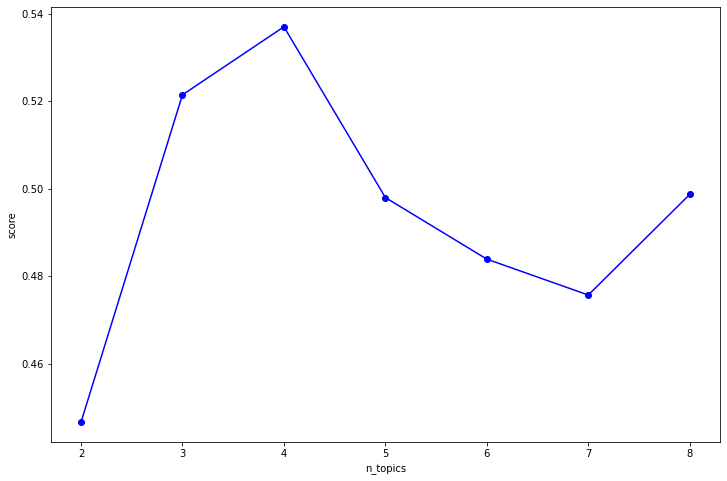

In [16]:
elbow_graph(n_topics_range, scores)

In [15]:
# select optimal number of topics to create final model
n_topics_opti = 4

model_opti = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=n_topics_opti, 
                     random_state=0)

In [16]:
# cluster visualisation
use_saved_vis = False
lda_filename = f'LDAvis_k_{model_opti.num_topics}_n_{nb_samples}'
lda_save_path = root_dir + '/data/lda_vis/' + lda_filename

pyLDAvis.enable_notebook()

if use_saved_vis:
    with open(lda_save_path, 'rb') as f:
        LDAvis = pickle.load(f)
else:
    LDAvis = pyLDAvis.gensim_models.prepare(model_opti, corpus, id2word)
    
    if os.path.isfile(lda_save_path):
        os.remove(lda_save_path)
        os.remove(lda_save_path + '.html')
        
    with open(lda_save_path, 'wb') as f:
        pickle.dump(LDAvis, f)
    pyLDAvis.save_html(LDAvis, lda_save_path + '.html')

LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.103352 -0.118038       1        1  38.411080
2     -0.021381  0.041038       2        1  28.244727
1     -0.197886 -0.013230       3        1  16.869292
0      0.115915  0.090230       4        1  16.474901, topic_info=        Term          Freq         Total Category  logprob  loglift
183     room   6814.000000   6814.000000  Default  30.0000  30.0000
204    order  16573.000000  16573.000000  Default  29.0000  29.0000
174  ordered  10391.000000  10391.000000  Default  28.0000  28.0000
193        u  18361.000000  18361.000000  Default  27.0000  27.0000
64    minute  13340.000000  13340.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
24       got   1293.654511  13221.947653   Topic4  -5.6368  -0.5211
29      know   1209.365000   9374.869571   Topic4  -5.7042  -0.2446
502    thing   1141.732504   6634.306282   Topic4  -5.7617   0.0436
56      went   1190.952969  11614.507469   Topic4  -5.7195  -0.4742
36      need   1124.247163   6220.185771   Topic4  -5.7772   0.0926

[382 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2289      4  0.993886      2am
1014      1  0.978647  account
1014      2  0.006857  account
1014      3  0.002939  account
1014      4  0.010776  account
...     ...       ...      ...
59        1  0.542988     year
59        2  0.176233     year
59        3  0.132175     year
59        4  0.148697     year
3799      3  0.990166   yogurt

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [17]:
def get_dominant_topics(ldamodel, corpus, texts):    
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        try:
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
        except:
            row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_rep = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_rep,4)]), ignore_index=True)
    sent_topics_df.columns = ['dominant_topic', 'Topic_rep']
    sent_topics_df['dominant_topic'] = sent_topics_df['dominant_topic'].astype(int)
    return(sent_topics_df)

In [18]:
# get dominant topic in each doc and its associated probability
df_with_topics = get_dominant_topics(ldamodel=model_opti, 
                                     corpus=corpus, 
                                     texts=list(data['text']))

separator = ' '
df = data['text'].apply(separator.join).reset_index()
lda_df = pd.concat([df, df_with_topics], axis=1)
lda_df.head()

,index,text,dominant_topic,Topic_rep
0,340462,food menu service place time owner sell care,3,0.5867
1,559902,"know store ghetto schnucks ,"" seems known walk...",2,0.5721
2,978596,got drink waited minute food ended leaving sin...,2,0.8111
3,76987,needed drug test future employer called told g...,3,0.3989
4,797931,needed tow called 56a eta 35p went 20p called ...,3,0.8208


In [19]:
topic_dist = pd.DataFrame()
topic_dist['topic_count'] = lda_df['dominant_topic'].value_counts()
topic_dist['ratio'] = round(topic_dist['topic_count'] / topic_dist['topic_count'].sum(), 2)
topic_dist

,topic_count,ratio
3,17307,0.35
2,15189,0.30
1,10968,0.22
0,6536,0.13


In [20]:
def word_cloud(text, excluded_words=[]):
    # for bigger plots
    plt.rcParams['figure.figsize'] = 12, 8

    wordcloud = WordCloud(background_color='white', 
                          stopwords=excluded_words, 
                          max_words=50)
    if type(text) == dict:
        wordcloud.fit_words(text)
        plt.imshow(wordcloud)
    elif type(text) == str:
        plt.imshow(wordcloud.generate(text))
        
    plt.axis('off')
    plt.show()

Topic 1:


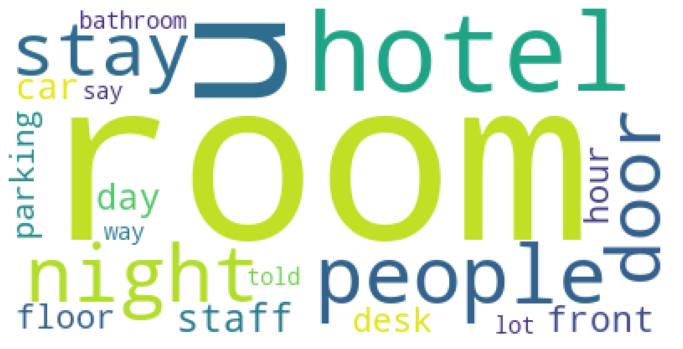



Topic 2:


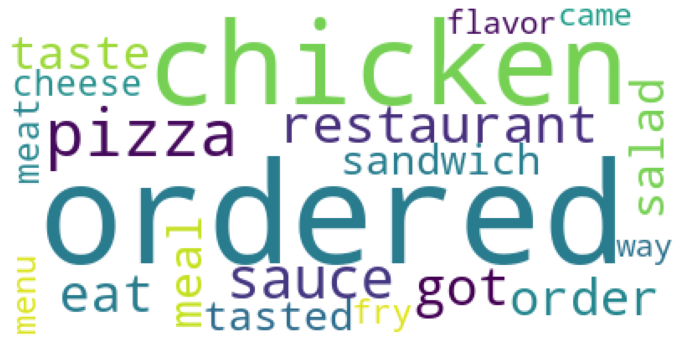



Topic 3:


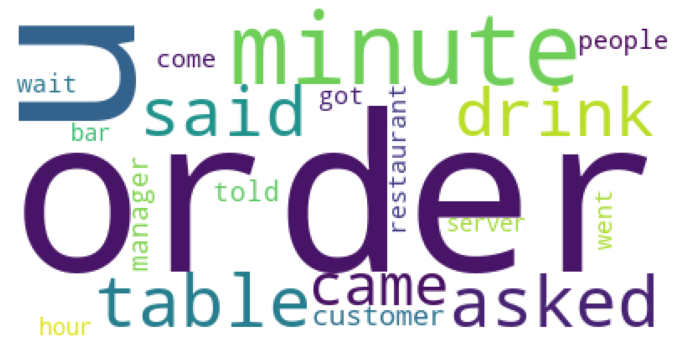



Topic 4:


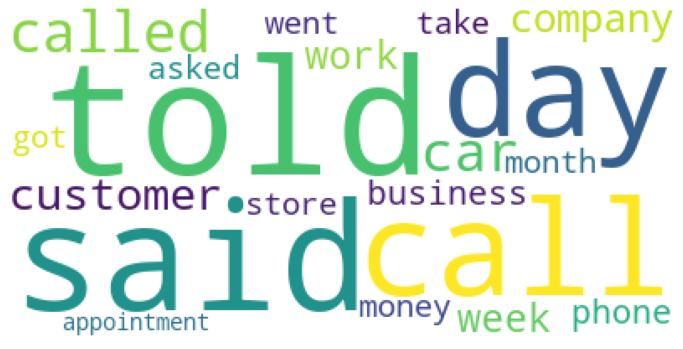

In [21]:
# word cloud for each topic
nb_words = 20

for t in range(model_opti.num_topics):
    print(f'Topic {t+1}:')
    n_top_words = dict(model_opti.show_topic(t, nb_words))
    word_cloud(n_top_words)
    print('\n')

In [22]:
from collections import OrderedDict

def get_doc_topic_dist(model, corpus, kwords=False):
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(model.num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

In [23]:
from sklearn.manifold import TSNE

def tsne_plot(X, pred, s=25, alpha=1):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(pred))))
    
    # for bigger plots
    plt.rcParams['figure.figsize'] = 12, 8
    
    plt.figure()
    for i in np.unique(pred):
        X_tsne_i = []
        for x, p in zip(X_tsne, pred):
            if p == i:
                X_tsne_i.append(x.reshape(1, -1))
        X_tsne_i = np.concatenate(X_tsne_i, axis=0)
        
        plt.scatter(X_tsne_i[:,0], 
                    X_tsne_i[:,1], 
                    color=colors[i], 
                    s=s, 
                    alpha=alpha, 
                    label=str(i))

    plt.legend()
    plt.xlim([np.min(X_tsne[:, 0]), np.max(X_tsne[:, 0])])
    plt.ylim([np.min(X_tsne[:, 1]), np.max(X_tsne[:, 1])])
    plt.show()

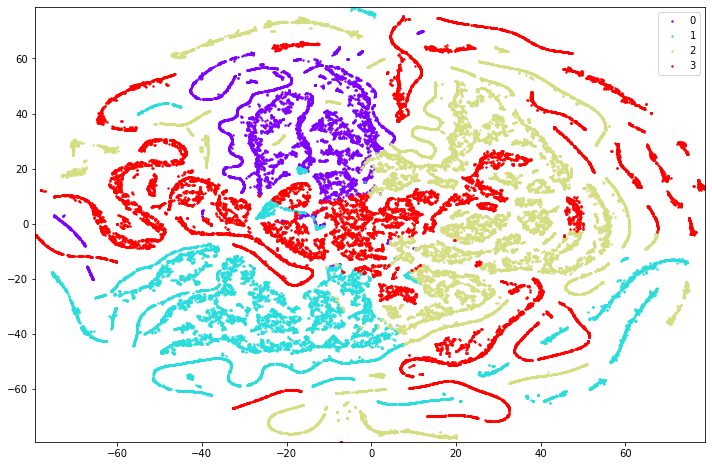

In [24]:
# tsne
X_lda, pred_lda= get_doc_topic_dist(model_opti, corpus, True)

tsne_plot(X_lda, pred_lda, s=2, alpha=1)

## NMF

In [25]:
# Non-negative Matrix Factorization
from gensim.models import Nmf
from gensim.models import CoherenceModel

print('n'.rjust(2), ':', 'score', '\n')
scores = []
for n_topics in n_topics_range:
    
    # create model with n_topics
    model = Nmf(corpus=corpus, 
              id2word=id2word, 
              num_topics=n_topics, 
              random_state=0
             )
    
    # keep score for graph
    coherence_model = CoherenceModel(model=model, 
                                         texts=list(data['text']), 
                                         corpus=corpus,
                                         dictionary=id2word, 
                                         coherence=coherence_metric)

    
    coherence_score = coherence_model.get_coherence()
    scores.append(coherence_score)
    print(str(n_topics).rjust(2), ':', round(coherence_score, 3))

 n : score 

 2 : 0.446
 3 : 0.423
 4 : 0.473
 5 : 0.441
 6 : 0.449
 7 : 0.447
 8 : 0.472


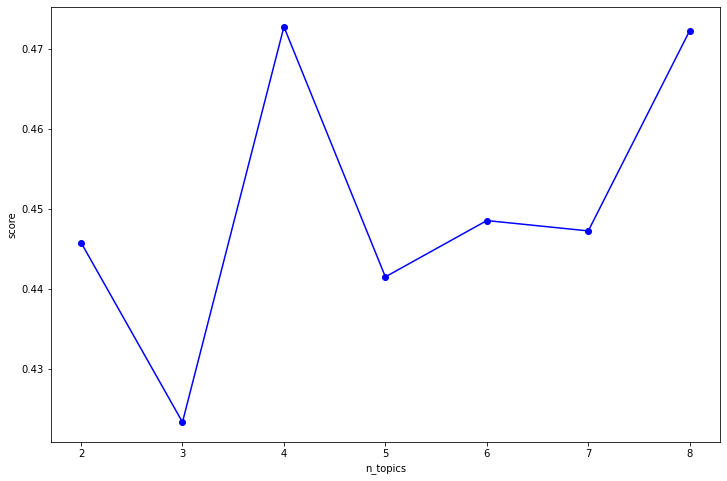

In [26]:
elbow_graph(n_topics_range, scores)

In [27]:
# select optimal number of topics to create final model
n_topics_opti = 4

model_opti = Nmf(corpus=corpus, 
                 id2word=id2word, 
                 num_topics=n_topics_opti, 
                 random_state=0
                )

Topic 1:


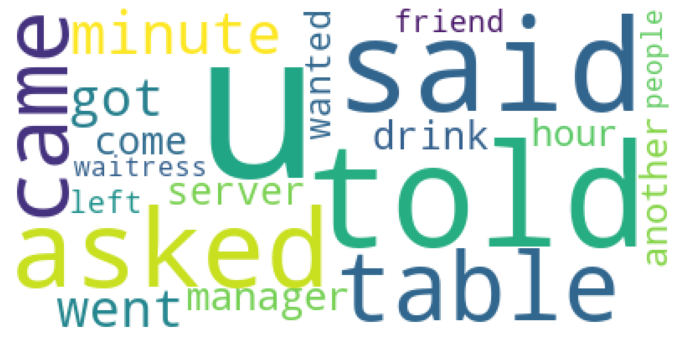



Topic 2:


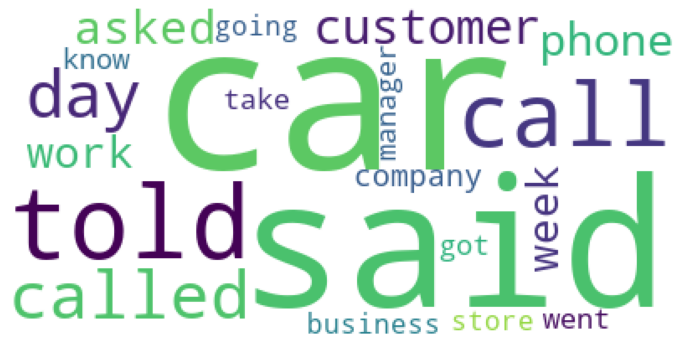



Topic 3:


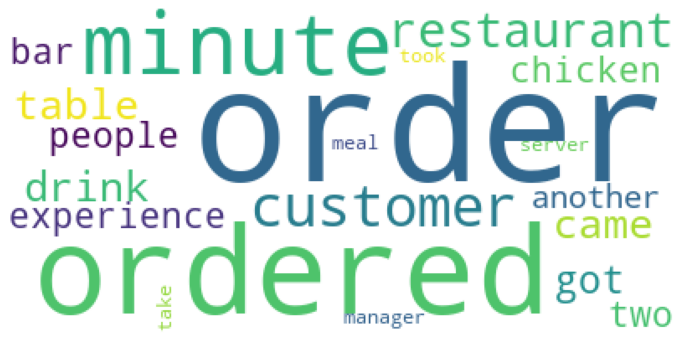



Topic 4:


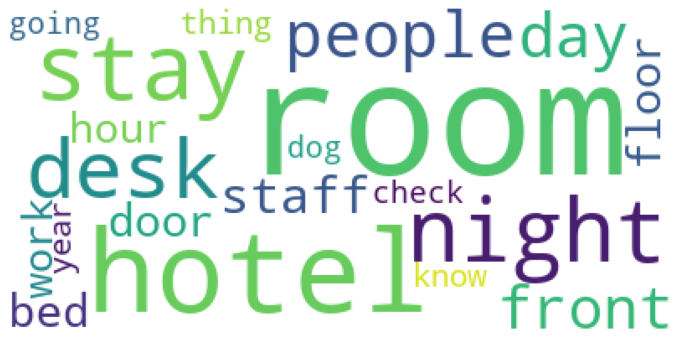

In [28]:
# word cloud for each topic
for t in range(model_opti.num_topics):
    print(f'Topic {t+1}:')
    n_top_words = dict(model_opti.show_topic(t, nb_words))
    word_cloud(n_top_words)
    print('\n')

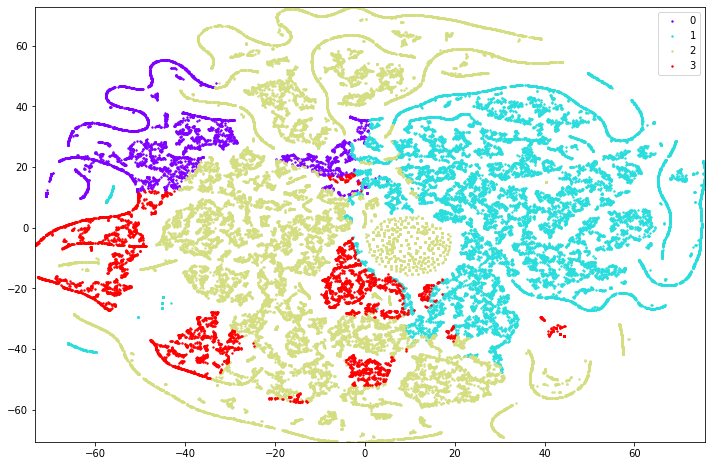

In [29]:
# tsne
X_nmf, pred_nmf = get_doc_topic_dist(model_opti, corpus, True)

tsne_plot(X_nmf, pred_nmf, s=2, alpha=1)